In [1]:
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
sns.set_palette('colorblind')
sns.set_color_codes(palette='colorblind')

In [2]:
CHAR_WIDTH = 4
CHAR_HEIGHT = 5
PIXEL_HEIGHT = (CHAR_HEIGHT + 2) * 3
PIXEL_WIDTH = (CHAR_WIDTH + 2) * 3
GRID = [0.2, 0.5, 0.8]
PIXEL_X = [col*(CHAR_WIDTH + 2) +1 for col in [0, 1, 2]]   #[1, 6, 11] # col *5 + 1
PIXEL_Y = [row*(CHAR_HEIGHT + 2) +1 for row in [0, 1, 2]]
POSSIBLE_CENTROIDS = [(x, y) for (x, y) in product(GRID, GRID)]
BORDER = 3
TOPLEFT = [(x + BORDER, y+BORDER) for (x, y) in product(PIXEL_X, PIXEL_Y)]
CENTRE = [(x+0.5, y+2.5) for (x, y) in TOPLEFT]
MAP_SCALE_PIXEL = {scaled:pixel for scaled,pixel in zip(POSSIBLE_CENTROIDS, TOPLEFT)}
CENTROID_ARRAY = np.array(POSSIBLE_CENTROIDS)
PIX_W = 21
PIX_H = 27
SCALED = [(x*PIX_W, y*PIX_H) for x,y in POSSIBLE_CENTROIDS]

In [26]:
# Load a test set. 
# file = 'toysets/toy_dataset_num2-6_nl-1.7_diff0-6_[5, 6, 7, 8, 9]same_lum[0.1, 0.3, 0.7, 0.9]_gw6_solarized_5000.pkl'
file = 'toysets/toy_dataset_num2-6_nl-1.7_diff0-6_[0, 1, 2, 3, 4]same_lum[0.0, 0.5, 1.0]_gw6_solarized_5000.pkl'
# file = 'toysets/toy_dataset_num2-6_nl-1.7_diff0-6_[0, 1, 2, 3, 4]same_lum[0.1, 0.3, 0.7, 0.9]_gw6_solarized_5000.pkl'
data = pd.read_pickle(file)

In [4]:
sum(data['predicted num'] == data['numerosity'])/5000

0.975

In [5]:
sum(data['pass count'] < 6)/5000

0.9346

In [17]:
def plot_pass_count_example(pass_count, numerosity, image_idx, ax, legend):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    half_glim = 3
    glim_wid = 6
    subset = data.query(f'`pass count`=={pass_count} and numerosity=={numerosity}').reset_index()
#     image = subset.loc[image_idx,'char image']
    image = subset.loc[image_idx,'noised image']
    coords = subset.loc[image_idx, 'glimpse coords'] # + half_glim
    candidates = subset.loc[image_idx, 'initial candidates']
    filled_locs = subset.loc[image_idx, 'initial filled locations']
    unique_cands = set()
    _ = [unique_cands.add(cand) for candlist in candidates for cand in candlist]
    
    # Plot glimpse bounding box according to ambiguity
    ambiguity = [len(cand_list) for cand_list in candidates]
    styles = ['-', '--', ':', '-.']
    cmap = mpl.cm.get_cmap('autumn')
    cmap = mpl.cm.get_cmap('Set1')
    cmap = mpl.cm.get_cmap('mako')
    border_col = sns.cubehelix_palette()[pass_count-1]
    colrs = np.linspace(0,1,len(coords))
    colrs = cmap(np.linspace(1,0,5))
    # Add outer border
    rect = plt.Rectangle((-0.5, -0.5), 24,27, fill=False, color=border_col, linewidth=8)
    rect = plt.Rectangle((-0.5, -0.5), 24,27, fill=False, color=border_col, linewidth=8)
    ax.add_patch(rect)
    labels = ['Unambiguous', 'Two Candidate Locations', 'Three Candidate Locations', 'Four Candidate Locations']
    rgba = cmap(0.0)
    # bounding = [plt.Rectangle((x-half_glim-0.5, y-half_glim-0.5), glim_wid, glim_wid, fc='none',ec=cmap(clr)) for (x,y), clr in zip(coords, colrs)]
#     bounding = [plt.Rectangle((x-half_glim-0.5, y-half_glim-0.5), glim_wid, glim_wid, fc='none', ec=cmap(i), linestyle=styles[amb]) for i, ((x,y), amb) in enumerate(zip(coords, ambiguity))]
    bounding = [plt.Rectangle((x-half_glim-0.5, y-half_glim-0.5), glim_wid, glim_wid, fc='none', ec=colrs[amb], label=labels[amb-1]) for i, ((x,y), amb) in enumerate(zip(coords, ambiguity))]

    ax.matshow(image, origin='upper', cmap='Greys', vmin=0, vmax=1)
    ax.set_xticks([],[])
    ax.set_yticks([],[])
    # plt.scatter(coords[:,0]-0.5, coords[:,1]-0.5, color='red', s=5)
    for box in bounding:
        ax.add_patch(box)
    # Add filled locations
    for loc in filled_locs:
        x,y = CENTRE[loc]
        ax.text(x, y, u'\u2713', color='r', fontsize=17, weight="bold")
    
    # Add candidate locations
    possible = [loc for loc in unique_cands if loc not in filled_locs]
    for loc in possible:
        x,y = CENTRE[loc]
        ax.text(x, y, '?', color='r', fontsize=16, weight="bold")
        
    notempty = filled_locs.union(set(possible))
    empty = [item for item in np.arange(9) if item not in notempty]
    for loc in empty:
        x,y = CENTRE[loc]
        ax.text(x, y, 'X', color='r', fontsize=15, weight="bold")
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), title='Glimpse Ambiguity', bbox_to_anchor=(1.05, 0.65))
    
    plt.tight_layout()

In [178]:
np.linspace(1,0,3)

array([1. , 0.5, 0. ])

In [179]:
ones = data[data['pass count']==1].reset_index()
twos = data[data['pass count']==2].reset_index()
fives = data[data['pass count']==5].reset_index()


In [210]:
sns.cubehelix_palette()

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8559578605899612, 0.6418993116910497, 0.6754191211563135],
 [0.739734329496642, 0.4765280683170713, 0.5959617419736206],
 [0.57916573903086, 0.33934576125314425, 0.5219003947563425],
 [0.37894937987024996, 0.2224702044652721, 0.41140014301575434],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

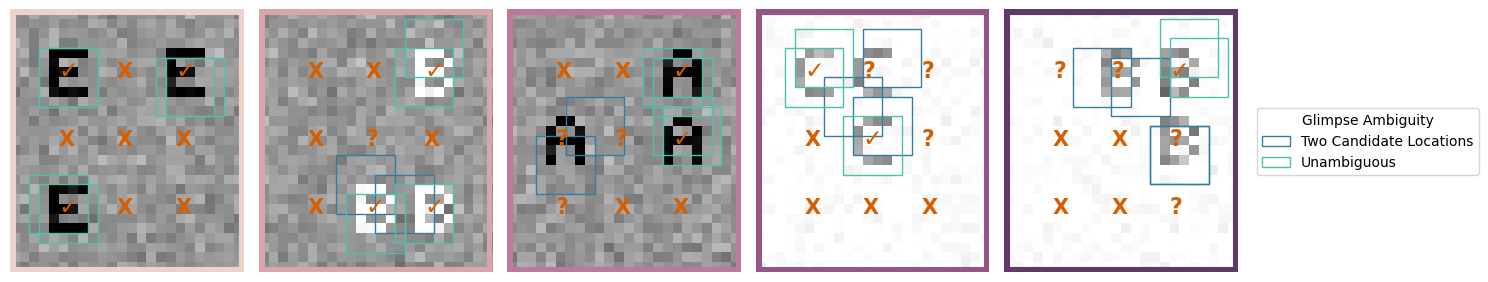

In [28]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))
idxs = [0, 0, 6, 0, 1]
for i in range(5):
    legend = True if i==4 else False
    plot_pass_count_example(i+1, 3, idxs[i], ax[i], legend=legend)
plt.savefig('figures/letters/noisy_train.png', dpi=400)

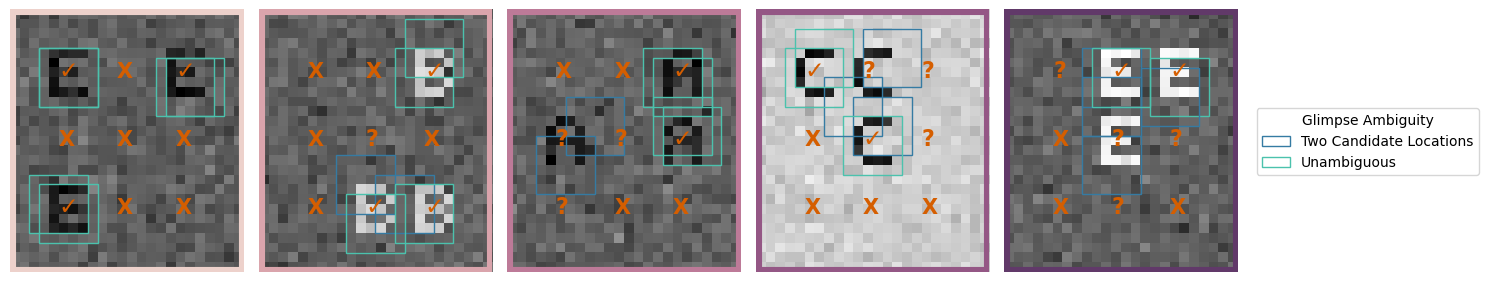

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(15,4))
idxs = [0, 0, 6, 0, 1]
for i in range(5):
    legend = True if i==4 else False
    plot_pass_count_example(i+1, 3, idxs[i], ax[i], legend=legend)
plt.savefig('figures/letters/noisy_test.png', dpi=400)

In [154]:
plot_pass_count_example(2, 3, 2, ax)


In [155]:
plot_pass_count_example(3, 3, 2, ax)


In [156]:
plot_pass_count_example(4, 3, 2, ax)


In [157]:
plot_pass_count_example(5, 3, 2, ax)

In [47]:
data.query('`pass count`==1 and numerosity==3').reset_index()

,index,xy,shape,numerosity,predicted num,count,locations,shape_map,pass count,unresolved ambiguity,special xy,special shape,lower bound,upper bound,min shape,min num,char glimpse coords,char glimpse pixels,char image,char overlap
0,131,"[[5.903392480610982, 16.194124119204808], [12....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.7272940904798042,...",3,3,3,"[0, 0, 1, 0, 0, 1, 1, 0, 0]","{2: 5, 5: 5, 6: 5}",1,False,False,False,3,6,1,0,"[[9, 19], [16, 7], [11, 20], [5, 20], [8, 20],...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...",15.0
1,136,"[[6.32052296061392, 13.073057747170143], [0.96...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58...",3,3,3,"[0, 0, 1, 0, 1, 1, 0, 0, 0]","{2: 8, 4: 8, 5: 8}",1,False,False,False,3,6,1,0,"[[9, 16], [4, 20], [10, 13], [5, 21], [11, 19]...","[[0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9,...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...",15.0
2,156,"[[13.397915252372279, 3.0352345727674597], [13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54...",3,3,3,"[0, 0, 0, 1, 0, 1, 1, 0, 0]","{3: 8, 5: 8, 6: 8}",1,False,False,False,3,6,1,0,"[[16, 6], [16, 8], [10, 21], [11, 7], [12, 7],...","[[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.1, 0.1,...","[[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,...",15.0
3,221,"[[13.421399613661023, 11.92373159353902], [12....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.515359602170235, ...",3,3,3,"[0, 0, 1, 0, 0, 1, 0, 1, 0]","{2: 5, 5: 5, 7: 5}",1,False,False,False,3,6,1,0,"[[16, 15], [16, 14], [8, 21], [11, 21], [11, 2...","[[0.9, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7, 0.7,...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...",15.0
4,421,"[[7.92562102807368, 5.219181187221908], [1.142...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.76...",3,3,3,"[1, 1, 0, 1, 0, 0, 0, 0, 0]","{0: 8, 1: 8, 3: 8}",1,False,False,False,3,6,1,0,"[[11, 8], [4, 15], [6, 13], [6, 6], [11, 5], [...","[[0.7, 0.1, 0.7, 0.1, 0.7, 0.7, 0.7, 0.1, 0.1,...","[[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,...",15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,4796,"[[11.064910679305736, 11.885182687354659], [12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,3,3,"[0, 0, 1, 0, 0, 0, 0, 1, 1]","{2: 9, 7: 9, 8: 9}",1,False,False,False,3,6,1,0,"[[14, 15], [16, 20], [5, 21], [15, 20], [16, 1...","[[0.7, 0.7, 0.7, 0.3, 0.7, 0.3, 0.7, 0.7, 0.7,...","[[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,...",15.0
69,4816,"[[13.875550769275529, 1.8959906680107101], [12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3080854...",3,3,3,"[0, 0, 0, 1, 0, 0, 1, 1, 0]","{3: 7, 6: 7, 7: 7}",1,False,False,False,3,6,1,0,"[[17, 5], [15, 13], [11, 8], [15, 14], [12, 8]...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...",15.0
70,4826,"[[2.6586104302705484, 3.9663775388163036], [1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,3,3,"[1, 1, 0, 0, 0, 0, 1, 0, 0]","{0: 9, 1: 9, 6: 9}",1,False,False,False,3,6,1,0,"[[6, 7], [4, 7], [16, 6], [6, 12], [17, 9], [4...","[[0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.1, 0.9,...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...",15.0
71,4941,"[[8.199905060102473, 11.186087909069206], [12....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.763072883463...",3,3,3,"[0, 0, 0, 0, 1, 0, 1, 1, 0]","{4: 6, 6: 6, 7: 6}",1,False,False,False,3,6,1,0,"[[11, 14], [16, 15], [13, 12], [15, 9], [15, 1...","[[0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.1, 0.9,...","[[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,...",15.0


In [41]:
# image = ones.loc[1,'char image']
# coords = ones.loc[1, 'xy']
image = fives.loc[0,'char image']
coords = fives.loc[0, 'xy']

<Figure size 640x480 with 0 Axes>

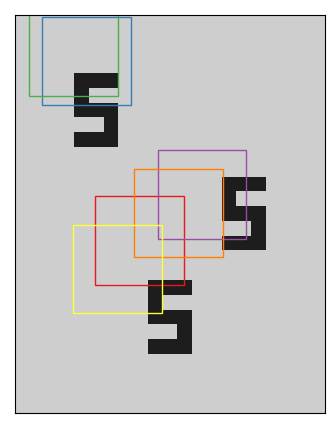

In [45]:
half_glim = 3
glim_wid = 6
cmap = mpl.cm.get_cmap('autumn')
cmap = mpl.cm.get_cmap('Set1')
plt.set_cmap(cmap)
colrs = np.linspace(0,1,len(coords))
rgba = cmap(0.0)
# bounding = [plt.Rectangle((x-half_glim-0.5, y-half_glim-0.5), glim_wid, glim_wid, fc='none',ec=cmap(clr)) for (x,y), clr in zip(coords, colrs)]
bounding = [plt.Rectangle((x-half_glim-0.5, y-half_glim-0.5), glim_wid, glim_wid, fc='none', ec=cmap(i)) for i, (x,y) in enumerate(coords)]

plt.matshow(image, origin='upper', cmap='Greys', vmin=0, vmax=1)
plt.xticks([],[])
plt.yticks([],[])
# plt.scatter(coords[:,0]-0.5, coords[:,1]-0.5, color='red', s=5)
for box in bounding:
    plt.gca().add_patch(box)